In [1]:
# General imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

## Missing data and rerun EDA
- handle missing data 
- rerun through the eda steps with clean data
- run boruta analysis for feature selection

In [2]:
# inspect dataset
radiomics_df = pd.read_csv("../motum/merged_radiomics_data.csv")
radiomics_df['modality'] = radiomics_df['Image'].str.extract(r"/([^/]+)\.nii\.gz$")[0]
radiomics_df['modality'].unique()
print(radiomics_df.shape)
print(radiomics_df.head())

# merge with metadata on subject_id
meta_df = pd.read_csv("../motum/Participants_wlabels.csv")
meta_headers = list(meta_df.columns)
merge_df = radiomics_df.merge(meta_df, how='left', left_on='subject_id', right_on='ID', validate='many_to_one')
print(merge_df.shape)
print(merge_df.columns)

def collapse_ratings(df, modality_col="modality", suffix="_img_rating"):
    """
    collapse modality-specific rating columns into a single column
    'img_rating' that matches the row's modality
    """
    df = df.copy()
    rating_cols = [c for c in df.columns if c.endswith(suffix)]

    modality_to_col = {c.replace(suffix, ""): c for c in rating_cols}

    # get col that matches modality
    target_cols = df[modality_col].map(modality_to_col)

    # collapse into new col corresponding rating
    col_indices = df.columns.get_indexer(target_cols)
    row_indices = np.arange(len(df))

    df["img_rating"] = df.to_numpy()[row_indices, col_indices]

    df = df.drop(columns=rating_cols)

    return df

merge_df = collapse_ratings(merge_df)
merge_df.columns
merge_df.head()

(268, 140)
                                               Image  \
0  /hdd3/bran/data/SD_glioma/submitted_data/MOTUM...   
1  /hdd3/bran/data/SD_glioma/submitted_data/MOTUM...   
2  /hdd3/bran/data/SD_glioma/submitted_data/MOTUM...   
3  /hdd3/bran/data/SD_glioma/submitted_data/MOTUM...   
4  /hdd3/bran/data/SD_glioma/submitted_data/MOTUM...   

                                                Mask  \
0  /hdd3/bran/data/SD_glioma/submitted_data/MOTUM...   
1  /hdd3/bran/data/SD_glioma/submitted_data/MOTUM...   
2  /hdd3/bran/data/SD_glioma/submitted_data/MOTUM...   
3  /hdd3/bran/data/SD_glioma/submitted_data/MOTUM...   
4  /hdd3/bran/data/SD_glioma/submitted_data/MOTUM...   

  diagnostics_Versions_PyRadiomics diagnostics_Versions_Numpy  \
0                           v3.0.1                     1.19.5   
1                           v3.0.1                     1.19.5   
2                           v3.0.1                     1.19.5   
3                              NaN                     

,Image,Mask,diagnostics_Versions_PyRadiomics,diagnostics_Versions_Numpy,diagnostics_Versions_SimpleITK,diagnostics_Versions_PyWavelet,diagnostics_Versions_Python,diagnostics_Configuration_Settings,diagnostics_Configuration_EnabledImageTypes,diagnostics_Image-original_Hash,...,IDH,GFAP,P53,Ki-67,Olig-2,surg_or_biop,EOR,molec_result,label,img_rating
0,/hdd3/bran/data/SD_glioma/submitted_data/MOTUM...,/hdd3/bran/data/SD_glioma/submitted_data/MOTUM...,v3.0.1,1.19.5,2.1.1.2,1.1.1,3.6.9,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},61e7c5403a3ba6d0730ef745a8025d22e8e66aa7,...,/,/,/,/,/,Surgery,Subtotal resection (STR),"ER (90%+), PR (90%+), HER-2 (+), Ki-67 (10%+),...",metastasis,2
1,/hdd3/bran/data/SD_glioma/submitted_data/MOTUM...,/hdd3/bran/data/SD_glioma/submitted_data/MOTUM...,v3.0.1,1.19.5,2.1.1.2,1.1.1,3.6.9,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},83d7595732eb5ffbad78cadb70095e0067914ba7,...,/,/,/,/,/,Surgery,Subtotal resection (STR),"CK7 (+), Ckpan(+), Napsin-A (-), TTF-1 (+), CK...",metastasis,2
2,/hdd3/bran/data/SD_glioma/submitted_data/MOTUM...,/hdd3/bran/data/SD_glioma/submitted_data/MOTUM...,v3.0.1,1.19.5,2.1.1.2,1.1.1,3.6.9,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},f182546914a5acb19d02ea31916f9c1ccd83da11,...,mutant,+,+,30%+,+,Surgery,Gross total resection (GTR),/,glioma,2
3,/hdd3/bran/data/SD_glioma/submitted_data/MOTUM...,/hdd3/bran/data/SD_glioma/submitted_data/MOTUM...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,wildtype,+,-,10%+,+,Surgery,Gross total resection (GTR),/,glioma,2
4,/hdd3/bran/data/SD_glioma/submitted_data/MOTUM...,/hdd3/bran/data/SD_glioma/submitted_data/MOTUM...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,/,/,/,/,/,Biopsy,Biopsy,-,metastasis,2


In [3]:
print(merge_df.columns)

Index(['Image', 'Mask', 'diagnostics_Versions_PyRadiomics',
       'diagnostics_Versions_Numpy', 'diagnostics_Versions_SimpleITK',
       'diagnostics_Versions_PyWavelet', 'diagnostics_Versions_Python',
       'diagnostics_Configuration_Settings',
       'diagnostics_Configuration_EnabledImageTypes',
       'diagnostics_Image-original_Hash',
       ...
       'IDH', 'GFAP', 'P53', 'Ki-67', 'Olig-2', 'surg_or_biop', 'EOR',
       'molec_result', 'label', 'img_rating'],
      dtype='object', length=156)


### Rerun through eda steps and investigate missing values:

In [4]:
# non_rad_feats = ["ManufacturerModelName","RepetitionTime","EchoTime","InversionTime","FlipAngle","SliceThickness","PixelSpacing", "Image","Mask"]

feat_families = {}
feat_cols = []
for c in merge_df.columns:
    if c.startswith("original_"): # only looking at num feats
        fam = c.split("_")[1]
        feat_families[fam] = feat_families.get(fam, 0) + 1
        feat_cols.append(c)

# no of feats in each family
print(feat_families)
print(feat_cols)

{'shape': 14, 'firstorder': 18, 'glcm': 24, 'gldm': 14, 'glrlm': 16, 'glszm': 16, 'ngtdm': 5}
['original_shape_Elongation', 'original_shape_Flatness', 'original_shape_LeastAxisLength', 'original_shape_MajorAxisLength', 'original_shape_Maximum2DDiameterColumn', 'original_shape_Maximum2DDiameterRow', 'original_shape_Maximum2DDiameterSlice', 'original_shape_Maximum3DDiameter', 'original_shape_MeshVolume', 'original_shape_MinorAxisLength', 'original_shape_Sphericity', 'original_shape_SurfaceArea', 'original_shape_SurfaceVolumeRatio', 'original_shape_VoxelVolume', 'original_firstorder_10Percentile', 'original_firstorder_90Percentile', 'original_firstorder_Energy', 'original_firstorder_Entropy', 'original_firstorder_InterquartileRange', 'original_firstorder_Kurtosis', 'original_firstorder_Maximum', 'original_firstorder_MeanAbsoluteDeviation', 'original_firstorder_Mean', 'original_firstorder_Median', 'original_firstorder_Minimum', 'original_firstorder_Range', 'original_firstorder_RobustMeanAb

In [5]:
# ------------ handle missing data ------------
# overall
print(merge_df.isna().sum())

# groupy by modality
na_by_mod = merge_df.groupby("modality")[feat_cols].apply(
    lambda df: df.isna().mean(axis=0).mean()
)
print(f"avg NA across features (by modality):\n {na_by_mod}")

# group by subject
na_by_subj = merge_df.groupby("subject_id")[feat_cols].apply(
    lambda df: df.isna().mean(axis=0).mean()
)
print(f"\navg NA across features (by subject):\n{na_by_subj}")
print(f"\nThese subjects are have most NA:{na_by_subj[na_by_subj > 0.25]}")

Image                                0
Mask                                 0
diagnostics_Versions_PyRadiomics    73
diagnostics_Versions_Numpy          73
diagnostics_Versions_SimpleITK      73
                                    ..
surg_or_biop                         0
EOR                                  0
molec_result                         0
label                                0
img_rating                           0
Length: 156, dtype: int64
avg NA across features (by modality):
 modality
flair    0.044776
t1       0.044776
t1ce     0.955224
t2       0.044776
dtype: float64

avg NA across features (by subject):
subject_id
sub-0001    0.25
sub-0002    0.25
sub-0003    0.25
sub-0004    0.25
sub-0005    0.25
            ... 
sub-0063    0.25
sub-0064    0.25
sub-0065    0.25
sub-0066    0.25
sub-0067    0.25
Length: 67, dtype: float64

These subjects are have most NA:subject_id
sub-0024    1.0
sub-0048    1.0
sub-0057    1.0
dtype: float64


majority of missingness is associated with t1ce and the subjects sub-0024, sub-0048 and sub-0057
drop these for downstream consideration

In [6]:
# remove t1ce and subjects with high missingness
print(merge_df.shape)
subj_to_drop = ["sub-0024", "sub-0048", "sub-0057"]
df = merge_df[
    (merge_df["modality"] != "t1ce") &
    (~merge_df['subject_id'].isin(subj_to_drop))
    ] 
print(df.shape)

# overall
print(df.isna().sum())

(268, 156)
(192, 156)
Image                               0
Mask                                0
diagnostics_Versions_PyRadiomics    0
diagnostics_Versions_Numpy          0
diagnostics_Versions_SimpleITK      0
                                   ..
surg_or_biop                        0
EOR                                 0
molec_result                        0
label                               0
img_rating                          0
Length: 156, dtype: int64


At this stage, the data is clean of most NAs. We are going to perform a bit more data cleaning:
- rename the variables to clean it up names (drop original_)
- create correlation plots

In [7]:
# # drop shape features
# print(len(feat_cols))
# # print(feat_cols)
# filt_feat_cols = [f for f in feat_cols if 'shape' not in f]
# print(len(filt_feat_cols))
# # print(filt_feat_cols)

# remove prefixes
df.columns = df.columns.str.removeprefix("original_")
rad_feat_cols = [c.replace("original_", "", 1) for c in feat_cols]
print(df.columns)
print(rad_feat_cols)


param_cols = [
    "modality", "ManufacturerModelName",
    "RepetitionTime", "EchoTime", "InversionTime",
    "FlipAngle", "SliceThickness", # dropped Pixel space since invalid type
]

meta_headers.extend(param_cols)
meta_cols = [i for i in meta_headers if not i.endswith("img_rating")]
meta_cols.append("img_rating")
meta_cols.remove("label")

rad_feat_df = df[rad_feat_cols]
meta_df = df[meta_cols]

# correlation plots
corr = rad_feat_df.corr()
corr.to_csv("../motum/correlation_results.csv", index=False, na_rep="NA")

# filtering for correlation threshold
corr_threshold = 0.9
abs_corr = corr.abs()

# identify all correlated pairs above threshold
upper_tri = abs_corr.where(
    np.triu(np.ones(abs_corr.shape), k=1).astype(bool)
)

# find all correlated pairs
correlated_pairs = []
for column in upper_tri.columns:
    correlated_features = upper_tri.index[upper_tri[column] > corr_threshold].tolist()
    for feature in correlated_features:
        correlated_pairs.append((column, feature, upper_tri.loc[feature, column]))

print(f"\nFound {len(correlated_pairs)} correlated pairs above threshold {corr_threshold}:")
for feat1, feat2, corr_value in correlated_pairs[:10]: # just showing the first 10
    print(f"  {feat1} <-> {feat2}: {corr_value:.3f}") # there are 298 correlated pairs, too many to go through manually

# defining a function that will handle highly correlated pairs
# will find the pair of features with the highest |correlation value| and drop the one that is more redundant
# based on mean |correlation value| of each feature with all other features
# it will keep doing that until no pair of features has a correlatino value above the threshold defined in the function
# returns keep list, drop list, and removal history
def corr_prune(X: pd.DataFrame, threshold=0.9, method='pearson'):
    feats = list(X.columns)
    history = []

    # computing absolute pearson correlation
    abs_corr = X.corr(method=method).abs()

    # setting diagonal to zero to make sure that duplicate feature pairs don't impact this analysis
    np.fill_diagonal(abs_corr.values, 0.0)

    # list of feature names
    active = feats.copy()

    while True:
        # upper-triangular max
        upper = np.triu(abs_corr.values, k=1)
        max_val = upper.max()
        if not np.isfinite(max_val) or max_val < threshold:
            break

        # take one max pair
        i_idx, j_idx = np.where(upper == max_val)
        i, j = int(i_idx[0]), int(j_idx[0])
        fi, fj = abs_corr.index[i], abs_corr.columns[j]

        # calculating mean |r| to others (excluding self)
        mean_i = abs_corr.loc[fi].drop(fi).mean()
        mean_j = abs_corr.loc[fj].drop(fj).mean()

        # drop more redundant - account for cases where the means are equal
        drop_feat = fi if (mean_i > mean_j or (mean_i == mean_j and fi > fj)) else fj
        keep_feat = fj if drop_feat == fi else fi

        history.append(
            (keep_feat, drop_feat, 
                float(max_val), 
                float(mean_i) if keep_feat == fi else float(mean_j),
                float(mean_j) if drop_feat == fj else float(mean_i)
            )
        )

        # remove feature from matrix
        active.remove(drop_feat)
        abs_corr = abs_corr.drop(index=drop_feat, columns=drop_feat)

    keep = active
    drop = [f for f in feats if f not in set(keep)]
    return keep, drop, history

# run this function to remove highly correlated pairs of features
keep_feats, drop_feats, removal_history = corr_prune(rad_feat_df)

# subset features accordingly
rad_feat_df_pruned = rad_feat_df[keep_feats]
rad_feat_cols_pruned = keep_feats 

print(f"Started with {len(rad_feat_cols)} features; kept {len(rad_feat_cols_pruned)}, dropped {len(drop_feats)} at |r| >= 0.9 using Pearson.")

# save the removal history
pd.DataFrame(removal_history, columns=["kept","dropped","max_abs_r","mean_abs_r_kept","mean_abs_r_dropped"])\
  .to_csv("../motum/corr_prune_history.csv", index=False)


Index(['Image', 'Mask', 'diagnostics_Versions_PyRadiomics',
       'diagnostics_Versions_Numpy', 'diagnostics_Versions_SimpleITK',
       'diagnostics_Versions_PyWavelet', 'diagnostics_Versions_Python',
       'diagnostics_Configuration_Settings',
       'diagnostics_Configuration_EnabledImageTypes',
       'diagnostics_Image-original_Hash',
       ...
       'IDH', 'GFAP', 'P53', 'Ki-67', 'Olig-2', 'surg_or_biop', 'EOR',
       'molec_result', 'label', 'img_rating'],
      dtype='object', length=156)
['shape_Elongation', 'shape_Flatness', 'shape_LeastAxisLength', 'shape_MajorAxisLength', 'shape_Maximum2DDiameterColumn', 'shape_Maximum2DDiameterRow', 'shape_Maximum2DDiameterSlice', 'shape_Maximum3DDiameter', 'shape_MeshVolume', 'shape_MinorAxisLength', 'shape_Sphericity', 'shape_SurfaceArea', 'shape_SurfaceVolumeRatio', 'shape_VoxelVolume', 'firstorder_10Percentile', 'firstorder_90Percentile', 'firstorder_Energy', 'firstorder_Entropy', 'firstorder_InterquartileRange', 'firstorder_Kurto

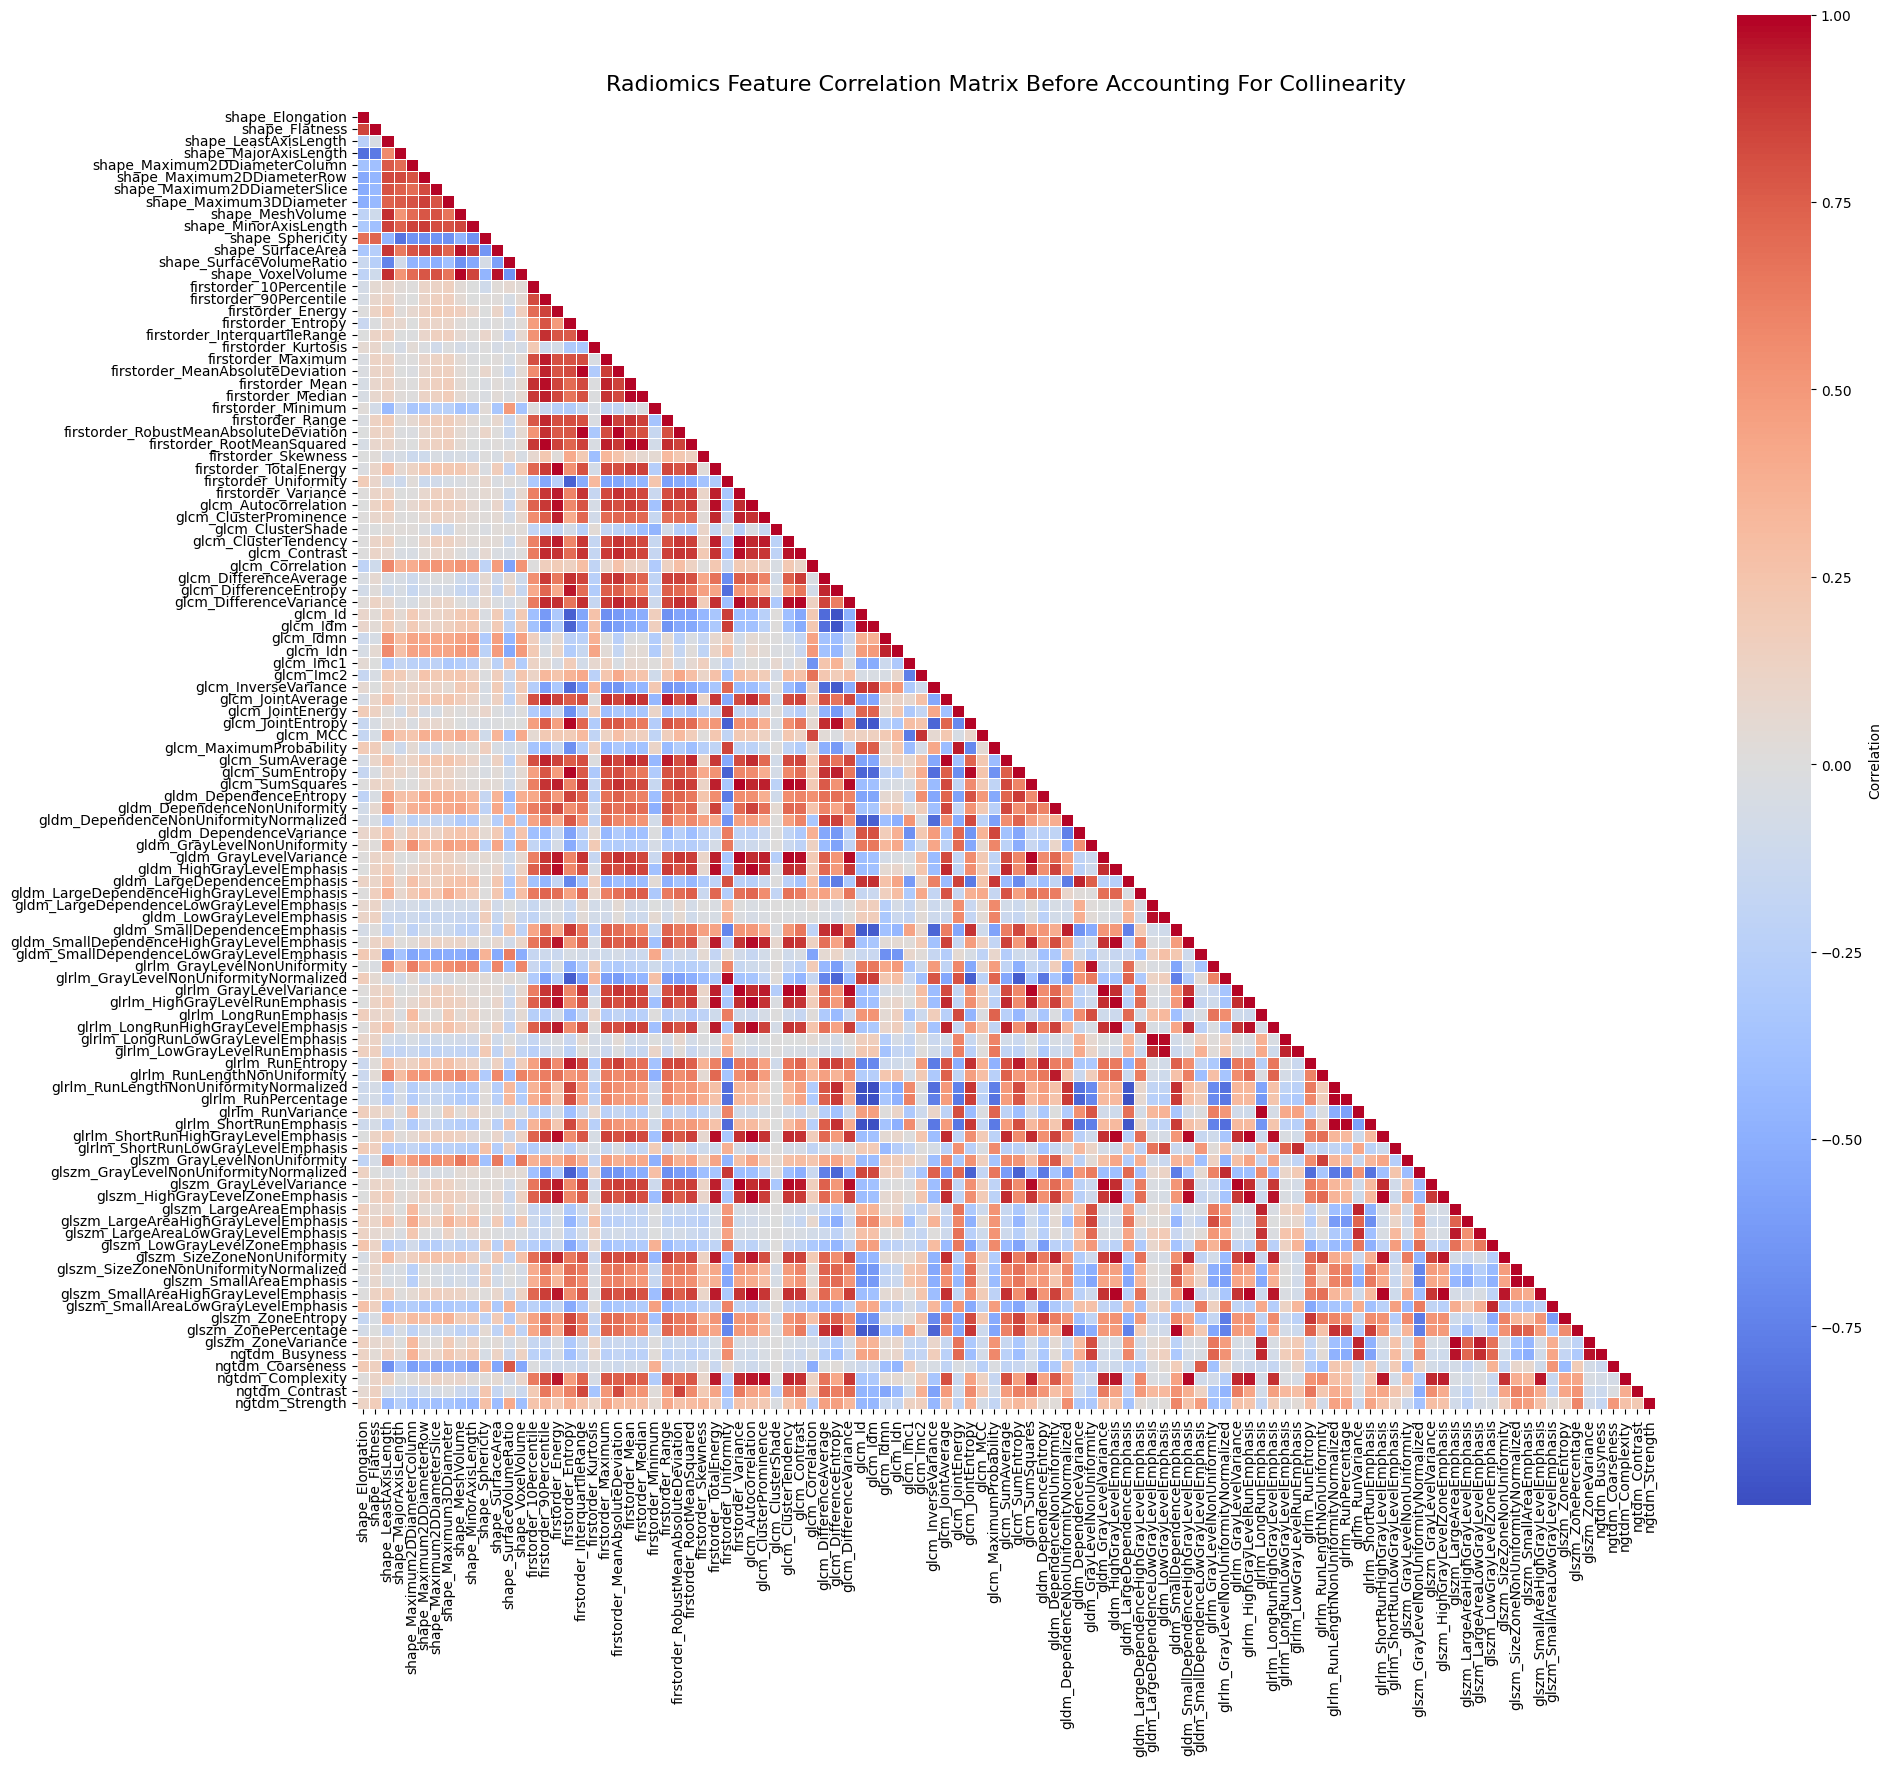

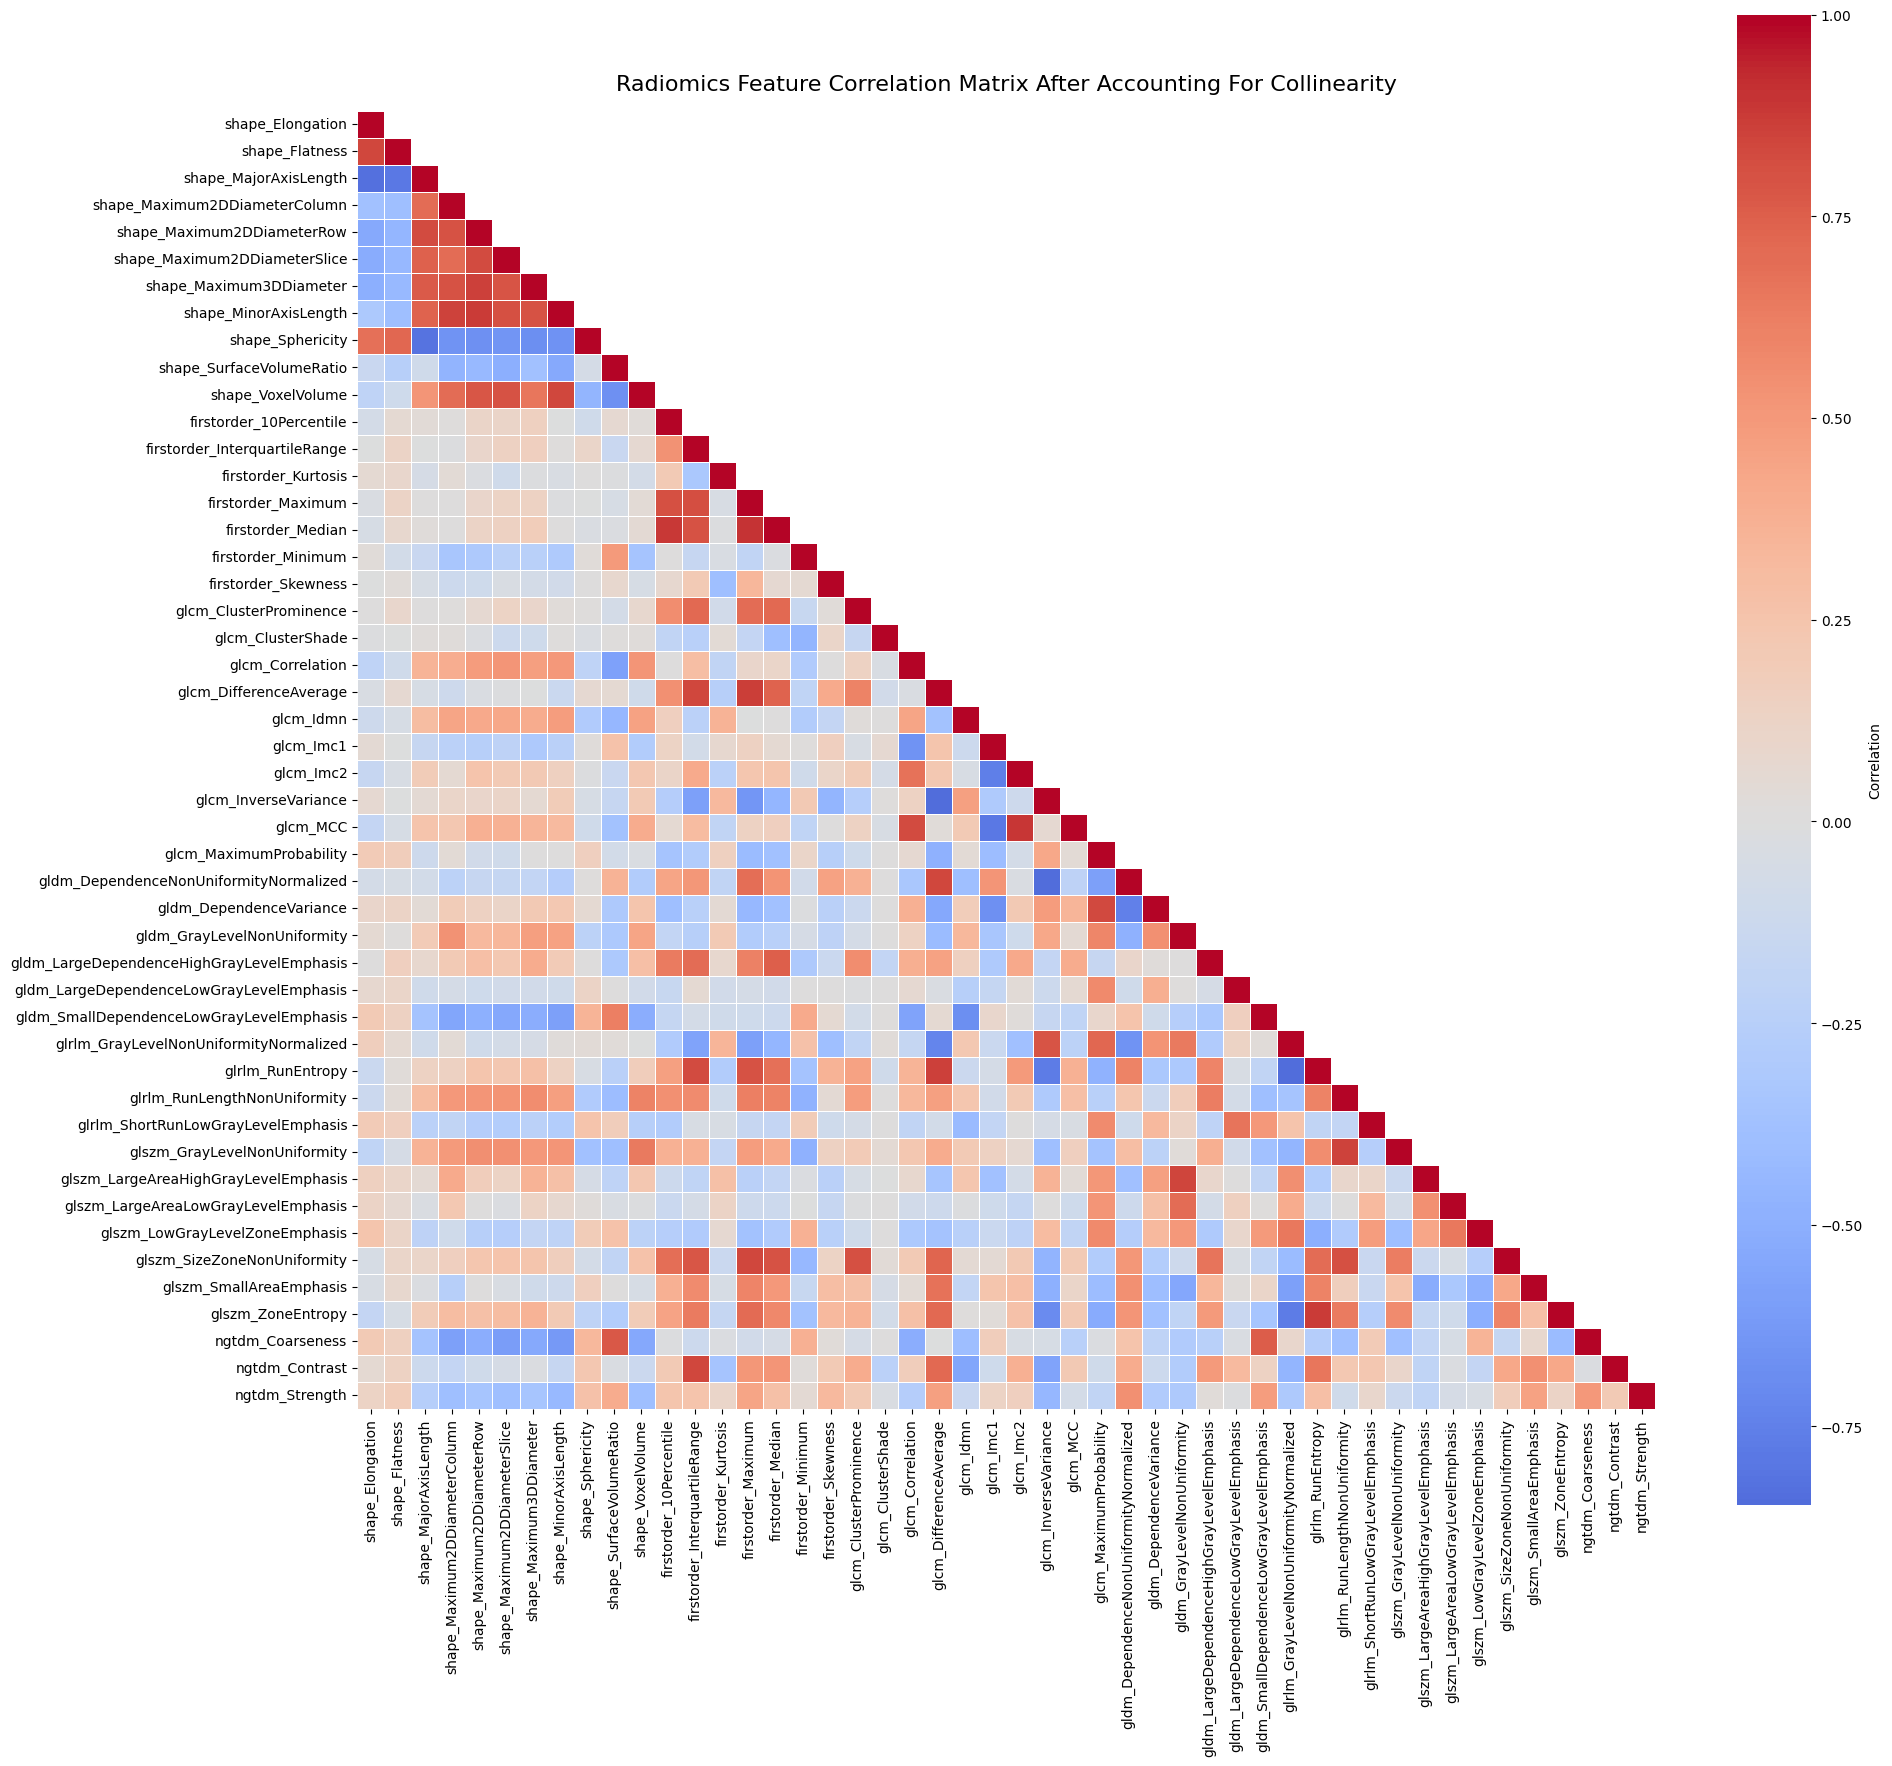

In [8]:
def get_lower_tri_heatmap(df):
    #https://stackoverflow.com/questions/2318529/plotting-only-upper-lower-triangle-of-a-heatmap
    mask = np.zeros_like(df, dtype=bool)
    mask[np.triu_indices_from(mask)] = True

    # Want diagonal elements as well
    mask[np.diag_indices_from(mask)] = False

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(20, 18))

    # # Generate a custom diverging colormap
    # cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns_plot = sns.heatmap(df, mask=mask, cmap="coolwarm", center=0,
            square=True, linewidths=.5, cbar_kws={"label": "Correlation"},
            xticklabels=df.columns, yticklabels=df.columns)
    return sns_plot

# generating one heatmap for before we accounted for collinearity
get_lower_tri_heatmap(corr)
plt.title("Radiomics Feature Correlation Matrix Before Accounting For Collinearity", fontsize=16, pad=15)
plt.tight_layout()
plt.show()

# generating one heatmap after
get_lower_tri_heatmap(rad_feat_df_pruned.corr())
plt.title("Radiomics Feature Correlation Matrix After Accounting For Collinearity", fontsize=16, pad=15)
plt.tight_layout()
plt.show()

Data is clean and collated as meta_df (rad_feat_df if radiomics data only). The radiomics columns are rad_feat_cols while the metadata cols are meta_headers.

In [9]:
# looking at the rad_feat_df and meta_df
print(rad_feat_df.head())
print(rad_feat_df.shape)
print(rad_feat_df_pruned.head())
print(rad_feat_df_pruned.shape)
print(meta_df.head())
print(meta_df.shape)

rad_feat_df.to_csv("../motum/radiomics_features_for_boruta.csv", index=False, na_rep="NA")
rad_feat_df_pruned.to_csv("../motum/radiomics_features_for_boruta_pruned.csv", index=False, na_rep="NA")
meta_df.to_csv("../motum/metadata_file_for_boruta.csv", index=False, na_rep="NA")

   shape_Elongation  shape_Flatness  shape_LeastAxisLength  \
0          0.373973        0.279708              51.958599   
1          0.736986        0.597354              54.145877   
2          0.823196        0.687723              43.306284   
5          0.739737        0.527651              28.562295   
6          0.851577        0.661225              53.560119   

   shape_MajorAxisLength  shape_Maximum2DDiameterColumn  \
0             185.759844                      95.238664   
1              90.642851                      86.702061   
2              62.970527                      66.426669   
5              54.131066                      54.580100   
6              81.001410                      84.534052   

   shape_Maximum2DDiameterRow  shape_Maximum2DDiameterSlice  \
0                  156.249993                    127.668776   
1                  109.128928                     95.650732   
2                   71.980903                     76.082038   
5                   

## Feature Engineering


Boruta is a python wrapper of the random forest algorithm. It performs a statistical test to assess the importance of features relative to synthetic permutations of features
https://towardsdatascience.com/feature-selection-with-boruta-in-python-676e3877e596/ 

key variables:
- X_rad: radiomics df
- X_met: metadata df
- y: labels (glioma or metastasis)

In [10]:
from sklearn.model_selection import GroupShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy

In [11]:
# from above:
# rad_feat_df = df[rad_feat_cols]
# meta_df = df[meta_cols]
rad_feat_cols_pruned.append("subject_id")
print(rad_feat_cols_pruned)
X_rad = df[rad_feat_cols_pruned]
print(X_rad.head())
X_clin = df[meta_cols]
y = df['label']

# data is such that there are multiple modalities for each subject
# split to ensure no data leakage (e.g. same patient appearing in train and test)
splitter = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(splitter.split(X_rad, y, groups=df["subject_id"]))

X_rad_train, X_rad_test = X_rad.iloc[train_idx], X_rad.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

# split clin data and response var on same idx
X_clin_train, X_clin_test = X_clin.iloc[train_idx], X_clin.iloc[test_idx]

# drop subject id
X_rad_sub_train = X_rad_train.drop("subject_id", axis=1)
X_rad_sub_test = X_rad_test.drop("subject_id", axis=1)

# BORUTA - help pls D: 

rf = RandomForestClassifier( # from scikitlearn
    n_jobs=-1,
    max_depth=5,
    class_weight='balanced',
    random_state=42
    )
boruta = BorutaPy(
    estimator=rf,
    perc=90,
    n_estimators='auto',
    max_iter=100,
    two_step=True,
    random_state=42,
    )


boruta.fit(X_rad_sub_train.values, y_train.values)

selected = X_rad_sub_train.columns[boruta.support_]
print(f"Selected features: {selected}")
print(f"Number of Selected features: {len(selected)}")


['shape_Elongation', 'shape_Flatness', 'shape_MajorAxisLength', 'shape_Maximum2DDiameterColumn', 'shape_Maximum2DDiameterRow', 'shape_Maximum2DDiameterSlice', 'shape_Maximum3DDiameter', 'shape_MinorAxisLength', 'shape_Sphericity', 'shape_SurfaceVolumeRatio', 'shape_VoxelVolume', 'firstorder_10Percentile', 'firstorder_InterquartileRange', 'firstorder_Kurtosis', 'firstorder_Maximum', 'firstorder_Median', 'firstorder_Minimum', 'firstorder_Skewness', 'glcm_ClusterProminence', 'glcm_ClusterShade', 'glcm_Correlation', 'glcm_DifferenceAverage', 'glcm_Idmn', 'glcm_Imc1', 'glcm_Imc2', 'glcm_InverseVariance', 'glcm_MCC', 'glcm_MaximumProbability', 'gldm_DependenceNonUniformityNormalized', 'gldm_DependenceVariance', 'gldm_GrayLevelNonUniformity', 'gldm_LargeDependenceHighGrayLevelEmphasis', 'gldm_LargeDependenceLowGrayLevelEmphasis', 'gldm_SmallDependenceLowGrayLevelEmphasis', 'glrlm_GrayLevelNonUniformityNormalized', 'glrlm_RunEntropy', 'glrlm_RunLengthNonUniformity', 'glrlm_ShortRunLowGrayLevel

Initially got no feats tried a few variables to make it less strict - logging doc refs here for report ease later:
- for RandomForestClassifier
    - max_depth: shallower tree

- for Boruta: https://github.com/scikit-learn-contrib/boruta_py 
    - perc: 100 -> 90
    The original method uses the maximum of the shadow features as a threshold in deciding which real feature is doing better than the shadow ones. This could be overly harsh.
    - max_iter: 100 (default) -> 200 (more iter)
    - two_step: False (default) -> True
    The correction for multiple testing was relaxed by making it a two step process, rather than a harsh one step Bonferroni correction.


Possible next steps:
- try decreasing the strictness more or picking feats w less support
- look into other splitting methods (stratified group k fold) if better for our app
- I think boruta does z standardization (?) but maybe we can preprocess data somehow for better signal??

once we select feats we can train model to classify and maybe consider other factors (e.g. centre influence, sex, age, grade etc.)
we should train the model and do cross val (something accounting for stratification by subject so no leakage)

- that should be good for prog report probably 

In [12]:
# preparing data for pycaret!
# only keeping boruta selected features and adding the target variable back into the dataframe
print(X_rad_train.columns)
train_df = X_rad_train[selected].copy()
train_df["label"] = y_train.values
train_df["subject_id"] = X_rad_train["subject_id"].values

test_df = X_rad_test[selected].copy()
test_df["label"] = y_test.values
test_df["subject_id"] = X_rad_test["subject_id"].values

# save as csv files
train_df.to_csv("../motum/data_for_pycaret_train.csv", index=False, na_rep="NA")
test_df.to_csv("../motum/data_for_pycaret_test.csv", index=False, na_rep="NA")

Index(['shape_Elongation', 'shape_Flatness', 'shape_MajorAxisLength',
       'shape_Maximum2DDiameterColumn', 'shape_Maximum2DDiameterRow',
       'shape_Maximum2DDiameterSlice', 'shape_Maximum3DDiameter',
       'shape_MinorAxisLength', 'shape_Sphericity', 'shape_SurfaceVolumeRatio',
       'shape_VoxelVolume', 'firstorder_10Percentile',
       'firstorder_InterquartileRange', 'firstorder_Kurtosis',
       'firstorder_Maximum', 'firstorder_Median', 'firstorder_Minimum',
       'firstorder_Skewness', 'glcm_ClusterProminence', 'glcm_ClusterShade',
       'glcm_Correlation', 'glcm_DifferenceAverage', 'glcm_Idmn', 'glcm_Imc1',
       'glcm_Imc2', 'glcm_InverseVariance', 'glcm_MCC',
       'glcm_MaximumProbability', 'gldm_DependenceNonUniformityNormalized',
       'gldm_DependenceVariance', 'gldm_GrayLevelNonUniformity',
       'gldm_LargeDependenceHighGrayLevelEmphasis',
       'gldm_LargeDependenceLowGrayLevelEmphasis',
       'gldm_SmallDependenceLowGrayLevelEmphasis',
       'glrlm_Gra